In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns
import itertools

import sklearn

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn import naive_bayes
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier 

from sklearn.tree import plot_tree

import time

In this data det there are measurements of different geometrical properties such as area, perimeter, compactness, length, width, assymetry, length of kernel groove for 3 types of wheat.A soft X-ray technique and GRAINS package were used to construct all seven, real-valued attributes.
The main target is to identify the tye of wheat according to different parameters outlines above. 


Sourse:
[The Network Data Repository with Interactive Graph Analytics and Visualization, Ryan A. Rossi and Nesreen K. Ahmed, 2015](http://networkrepository.com/seeds-dataset.php)


In [2]:
# Uploading Data set and rewieing main data table using Head function. 

#np.random.seed(15)
data = pd.read_csv('seeds_dataset (1).csv')
x = data.iloc[:, 0:-1]
y = data.iloc[:, -1]
data.head(5)

# I added up a line np.random.seed(10) so ramdomasation to be more determined,
#and the graphs for accuracy saved the trend, while the confusion matrix 
#results differed. Setting a seed eaual to 15 gives almost the same distribution
#for results in confucin matrix as comparing to those I had before uding seed.
# I left it here just in case if you want to have a look
#when changing the seed there are some differences in the graphs as ramdom 
#samples differ, but overall results are almost the same which are specified 
#in the last section of this document 


,area,perimeter,compactness,length,width,assymetry,length of kernel groove,type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


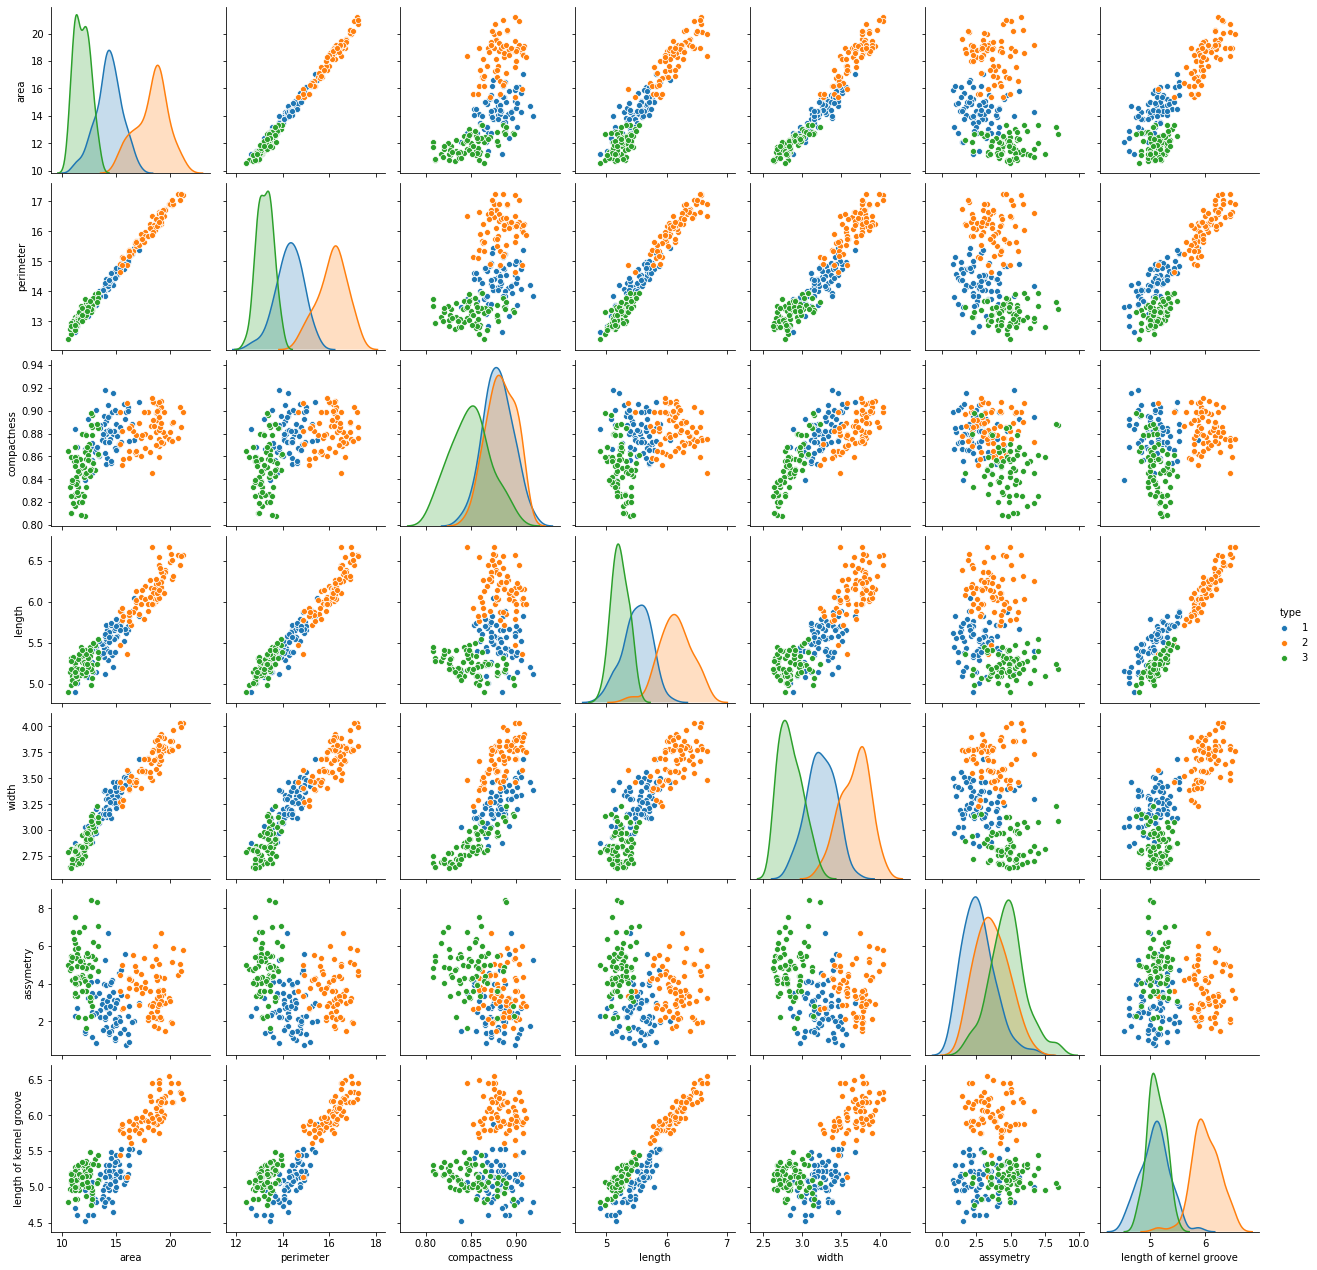

In [3]:
# drowing the main plot to see how parameters for 3 different types 
#of wheat are presented 
sns.pairplot(data, hue="type")

Deviding the main data into training and testing, choosing random 20% of data for testing. There will be 10 devisions like this done so we can measure learning curve parameters for a few times for more precise analysis. 

In [4]:
class Split:
    def __init__(self, train, test):
        self.train = train
        self.test = test

def random_split(x, y, size):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=size)
    return Split((X_train, y_train), (X_test, y_test))

data_splits = []
for i in range(10):
    data_splits.append(random_split(x, y, 0.2))


In [5]:
# learn model, returns train and test data predictions
def fit(model, train_set, test_set):
    x_train, y_train = train_set
    x_test, y_test = test_set
    model.fit(x_train, y_train)
    return (y_train, model.predict(x_train)), (y_test, model.predict(x_test))

def accuracy(answers):
    return [metrics.accuracy_score(real, prediction) for real, prediction in answers]

def confusion(answers):
    return [metrics.confusion_matrix(real, prediction) for real, prediction in answers]

def stopwatch_fit(*argv, **kwarg):
    begin = time.time()
    res = fit(*argv, **kwarg)
    diff = time.time() - begin
    return diff, res

# Usual analysis of the model 
# model          model for learning
# data_splits    list of Splits
# mean           if True returns mean time/accuracy, else list of time/accuracy for every Split
# plot           if False all output os supressed
# confusion      if True plots confusion matrix
# curve          if True plots learning curve
#
# return         tuple (time, (train accuracy, test accuracy))

def analyze(model, data_splits, mean=False, plot=True, confusion=True, curve=True):
    times = []
    train_accuracy = []
    test_accuracy = []
    result = None
    for data_split in data_splits:
        fit_time, result = stopwatch_fit(model, data_split.train, data_split.test)
        acc = accuracy(result)
        times.append(fit_time)
        train_accuracy.append(acc[0])
        test_accuracy.append(acc[1])
        
    if plot:
        print('Average time:', np.mean(times))
        print('Average train accuracy:', np.mean(train_accuracy))
        print('Average test accuracy:', np.mean(test_accuracy))
    if curve and plot:
        # learning curve
        train_sizes, train_scores, test_scores = learning_curve(
                                                model, 
                                                data_splits[0].train[0], 
                                                data_splits[0].train[1], 
                                                return_times=False, train_sizes=np.linspace(.1, 1.0, 30))
        train_scores = np.mean(train_scores, axis=1)
        test_scores = np.mean(test_scores, axis=1)
        plt.plot(train_sizes, train_scores, color='blue')
        plt.plot(train_sizes, test_scores, color='red')
        plt.xlabel("Train sizes")
        plt.ylabel("Accuracy")
    if confusion and plot:
        plot_confusion_matrix(model, data_splits[-1].test[0], data_splits[-1].test[1])
        
    if mean:
        times = np.mean(times)
        train_accuracy = np.mean(train_accuracy)
        test_accuracy = np.mean(test_accuracy)
    return times, (train_accuracy, test_accuracy)

# Comparing models depending on the parameters 
# models       list of models
# xs           list of values for x-axis
# data_splits  list of Splits for learning
# xlabel       label for x axis
# plot         if True plots results
#
# return       list of mean time/accuracy for every model
def loop_analyze(models, xs, data_splits, xlabel="", plot=True):
    times = []
    train_accuracy = []
    test_accuracy = []

    for model in models:
        model_time, acc = analyze(model, data_splits, mean=True, plot=False, curve=False)
        times.append(model_time)
        train_accuracy.append(acc[0])
        test_accuracy.append(acc[1])
    if plot:
        plt.figure(figsize=(24, 6))
        ax = plt.subplot(121)
        ax.plot(xs, train_accuracy, color='blue')
        ax.plot(xs, test_accuracy, color='red')
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Accuracy")
        ax = plt.subplot(122)
        ax.plot(xs, times, color='blue')
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Time")
    return times, train_accuracy, test_accuracy


# Main Analysis

Then there will be extraction of main results for different models will follow - average time, train and test accuracy (as we do measurements 10 times, only the average will be outlines). Then learning curve and confusion matrix for all methods outlined in this project for the result of all 10 randomly selected sample data for more visual representation. 

### K nearest neighbors

Average time: 0.008316826820373536
Average train accuracy: 0.9250000000000002
Average test accuracy: 0.8714285714285713


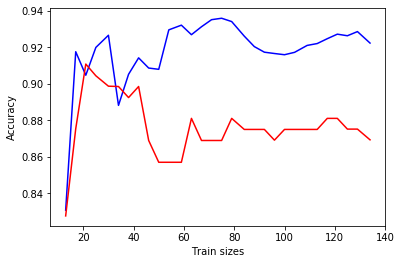

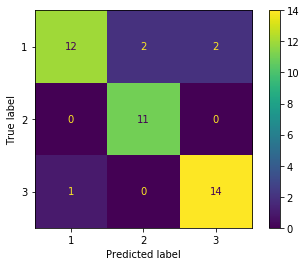

In [9]:
model = KNeighborsClassifier()
_ = analyze(model, data_splits)

The results for accuracy for training data represented by a blue line, while  testing data shown in red line as for following algorithms outlined in this project. It can be seen that the accuracy increases with the training sized and they are positively correlated. For testing there are minor fluctuations  abount 0.87 
The clear pattern can be seen  in the confusion matrix, there only few cases(4-5) outside the diagonal. 

This analysis below show how quantity of chosen nearest neighbours influences on time and accuracy of the test. 


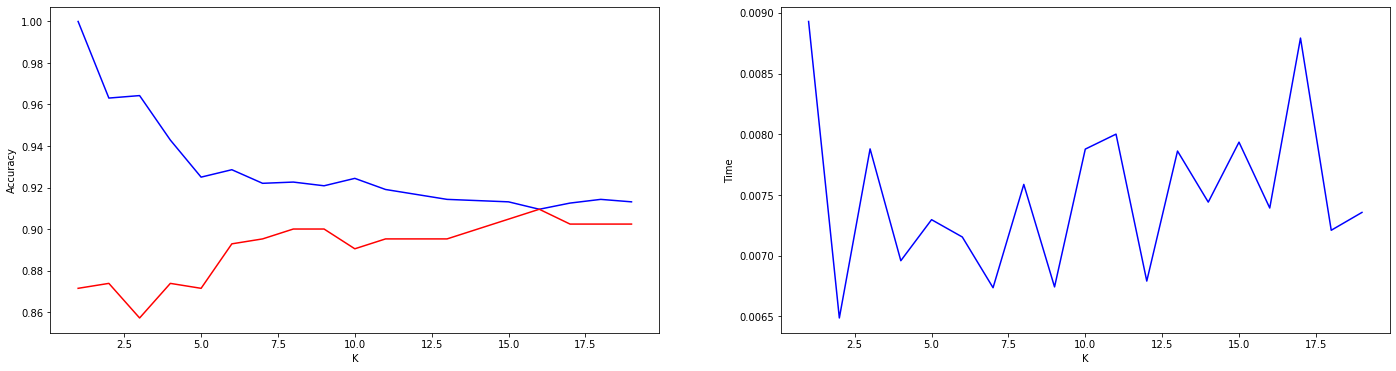

In [18]:
xs = list(range(1, 20))
models = (KNeighborsClassifier(n_neighbors=n_neighbors) for n_neighbors in xs)
_ = loop_analyze(models, xs, data_splits, "K")

It can be seen that with a small amount of K chosen, the test results for trainign data were the highest, however with the inclease in K there is downward sloping trend and the accuracy fluctuates between .90 and .093 for both training data. for testing data fluctuations are between 0.9 and 0.91 which is slightly lower.
However there can not be seen a trend in timimg fluctuations depending on the K defined. The largest amont of time that was required to run the algorithm was when the number of K increased to different numbers each time I run it 

### Logistic regression

Average time: 0.06436421871185302
Average train accuracy: 0.9267857142857142
Average test accuracy: 0.9142857142857144


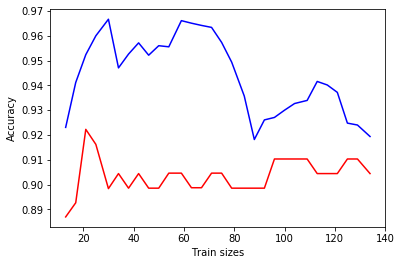

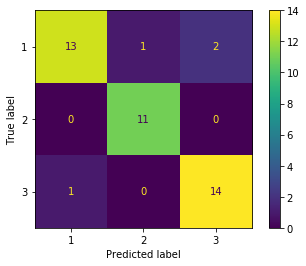

In [19]:
model = LogisticRegression(max_iter=1000, tol=0.01)
_ = analyze(model, data_splits)

### Classification trees

Analysis of the function for classification trees.Both of the results for Gini and Entropy showed similar output.

Average time: 0.0031571388244628906
Average train accuracy: 1.0
Average test accuracy: 0.9047619047619048


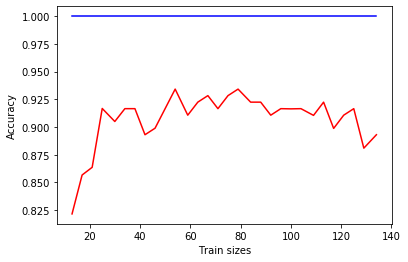

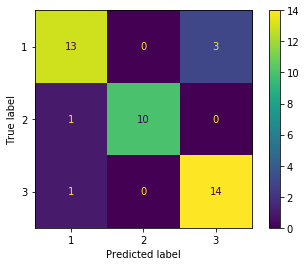

In [31]:
#Gini 

model = DecisionTreeClassifier(criterion="gini")
_ = analyze(model, data_splits)

There can be seen high accuracy results for Training data, however the result for Test accuracy are not as curtain; however,  it can be seen that it remained fluctuating around values of 0.89 and 0.935 after the train size increases up to 30. 

Average time: 0.002859044075012207
Average train accuracy: 1.0
Average test accuracy: 0.9095238095238095


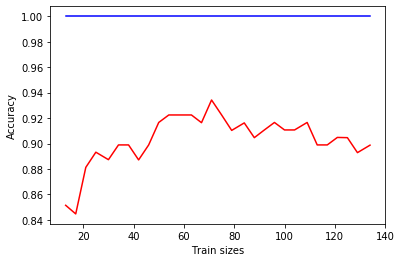

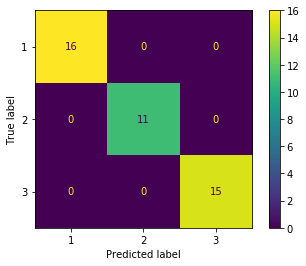

In [32]:
# Entropy 

model = DecisionTreeClassifier(criterion="entropy")
_ = analyze(model, data_splits)

The graph represents almost the same result as for Gini, outlined above.

Following is the analysis that shows how the depth of the tree influences on the accuracy and time required to run.

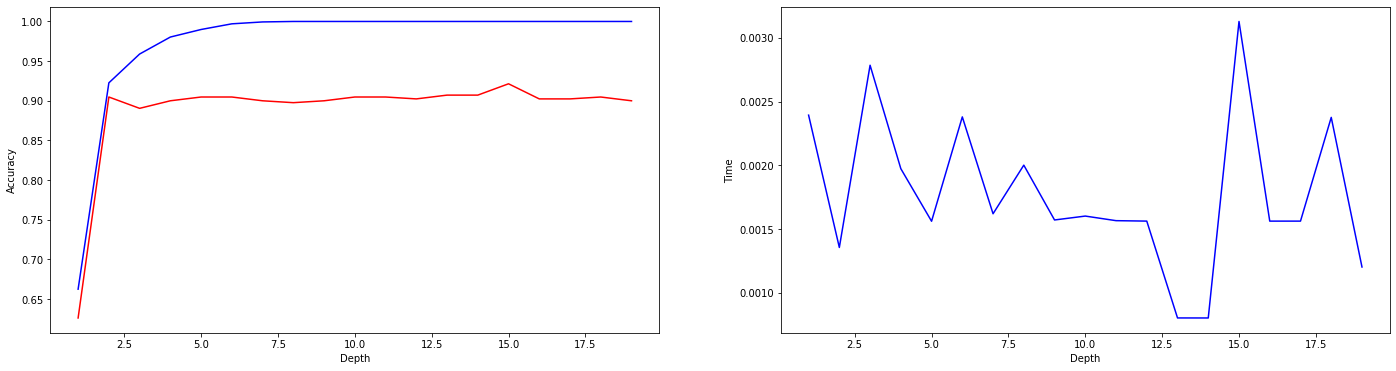

In [33]:
xs = list(range(1, 20))
models = (DecisionTreeClassifier(max_depth=depth) for depth in xs)
_ = loop_analyze(models, xs, data_splits, "Depth")


Comparison for ramrom and best devision is followed. With a small loss of accuracy, generally ramdom selection works faster. 

In [23]:
model = DecisionTreeClassifier(criterion="gini", splitter="best", max_depth=7)
_ = analyze(model, data_splits, curve=False, confusion=False)
print()
model = DecisionTreeClassifier(criterion="gini", splitter="random", max_depth=7)
_ = analyze(model, data_splits, curve=False, confusion=False)

Average time: 0.0025699377059936524
Average train accuracy: 0.9994047619047619
Average test accuracy: 0.9071428571428571

Average time: 0.0020008087158203125
Average train accuracy: 0.9886904761904761
Average test accuracy: 0.8880952380952382


### Random Forest & Extra trees

General comparison between Random Forest and Extra Trees

In [34]:
_ = analyze(RandomForestClassifier(), data_splits, curve=False, confusion=False)
print()
_ = analyze(ExtraTreesClassifier(), data_splits, curve=False, confusion=False)

Average time: 0.11775171756744385
Average train accuracy: 1.0
Average test accuracy: 0.9333333333333333

Average time: 0.0858802080154419
Average train accuracy: 1.0
Average test accuracy: 0.930952380952381


How accuracy of  Random Forest Classifier depends on the number of estimators

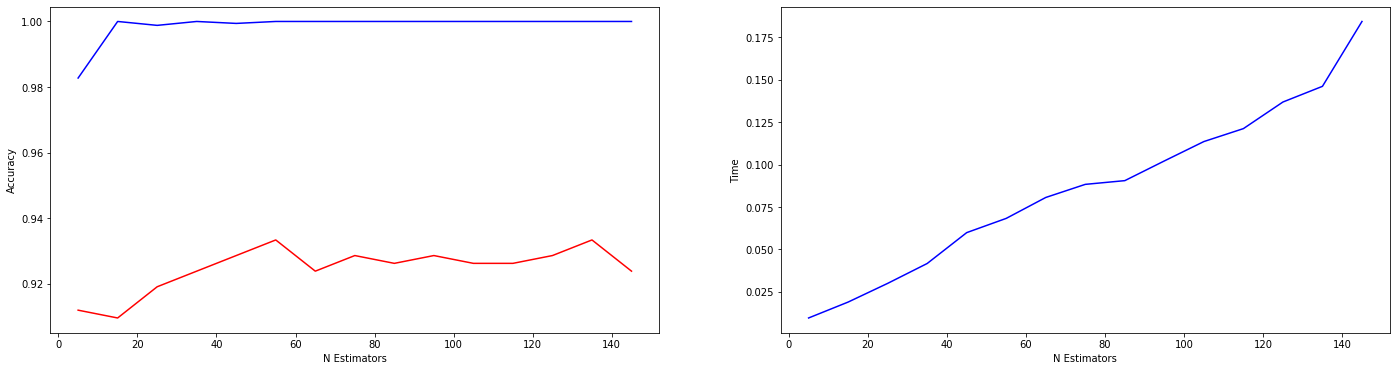

In [35]:
xs = range(5, 150, 10)
models = (RandomForestClassifier(n_estimators=n_estimators) for n_estimators in xs)
_ = loop_analyze(models, xs, data_splits, "N Estimators")


The graph shows that the time required almost proportionalyly increases with thee number of estimates except for few minor fluctuations. So it will be time consuming with the large number of estimators. 
The results for training samples are more constant and precise comparing to testing. 

### Gradient Boost

Average time: 0.20025551319122314
Average train accuracy: 1.0
Average test accuracy: 0.9404761904761905


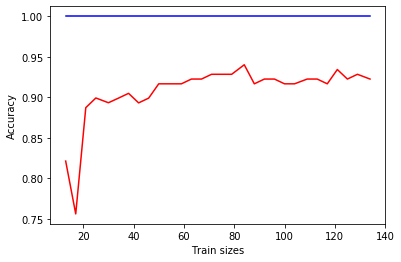

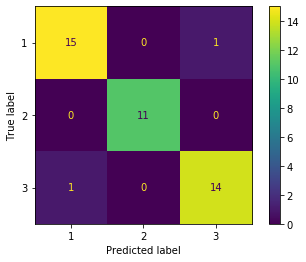

In [36]:
model = GradientBoostingClassifier()
_ = analyze(model, data_splits)

The accuracy for training data is at highest point, while the results for testing data were higher than 0.9 up starting at the point where the training sized increased to 20. 

### Gaussian Naive Bayes

Average time: 0.0028061151504516603
Average train accuracy: 0.9101190476190475
Average test accuracy: 0.9095238095238095


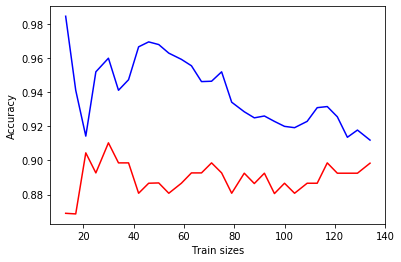

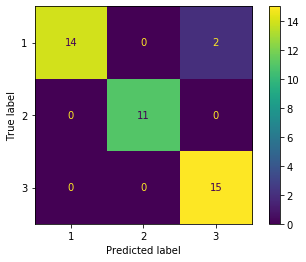

In [30]:
model = naive_bayes.GaussianNB()
_ = analyze(model, data_splits)

The results on accuracy for both trainig and testing sets are following same pattern (with increasing number of train sizes) on a high level of accuracy.
The accuracy is high for both small and large train sizes in both cases. 

# All

General comparison of algorithms depending on time and accuracy. 

Logistic regression
Decision tree
Decision tree (max_depth = 5)
KNN (k = 2)
Random forest
Extra trees
Gradient Boosting
Naive Bayes - Gaussian


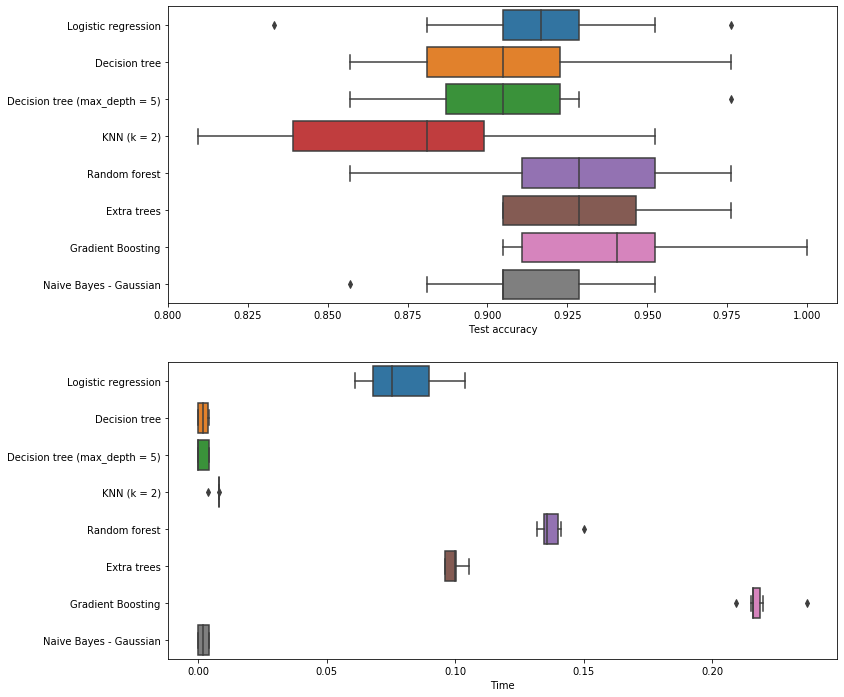

In [38]:
models = [
    ["Logistic regression",           LogisticRegression(max_iter=1000, tol=0.01)],
    ["Decision tree",                 DecisionTreeClassifier()],
    ["Decision tree (max_depth = 5)", DecisionTreeClassifier(max_depth=5)],
    ["KNN (k = 2)",                   KNeighborsClassifier(n_neighbors=2)],
    ["Random forest",                 RandomForestClassifier()],
    ["Extra trees",                   ExtraTreesClassifier()],
    ["Gradient Boosting",             GradientBoostingClassifier()],
    ["Naive Bayes - Gaussian",        naive_bayes.GaussianNB()],
]

times = []
train_acc = []
test_acc = []
keys = []
for name, model in models:
    print(name)
    t, acc = analyze(model, data_splits, plot=False, curve=False, confusion=False)
    times.append(t)
    train_acc.append(acc[0])
    test_acc.append(acc[1])
    keys.append(name)
    
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(211)
data = pd.DataFrame(data=test_acc, index=keys).transpose()
_ = sns.boxplot(data=data, orient="h")
_ = ax.set_xlabel("Test accuracy")

ax = fig.add_subplot(212)
_ = ax.set_xlabel("Time")
data = pd.DataFrame(data=times, index=keys).transpose()
_ = sns.boxplot(data=data, orient="h")

How to read the box chart: 
    1) the beginnning of the line is the minimum among the data 
    2)from the beginning to the point when the rectangular starts - here are quater of all measurements 
    3)from the beginning of the rectangular to the line - one more quater 
    4)the line shows Mediana
    5)and the last two parts (the end of the rectangular and the line itself) constitute 50 more % of the data 
    6) the end of the line shows the gighest result in measurements 
    7)separate points are outliers. 

The models showed good accuracy on average, but Extra Trees and Gradient Boosting have a smaller scatter for different training data. 

Over a number of regressions there finding found to be constant: 

Random Forest and Gradienr boosting also have the largest median, and for this dataset, using it on average will often give high results, but these methods are the most time consuming. Therefore the highest mean for accuracy is also accosicted with more time for running the code. 